# Deep Voice Recognition

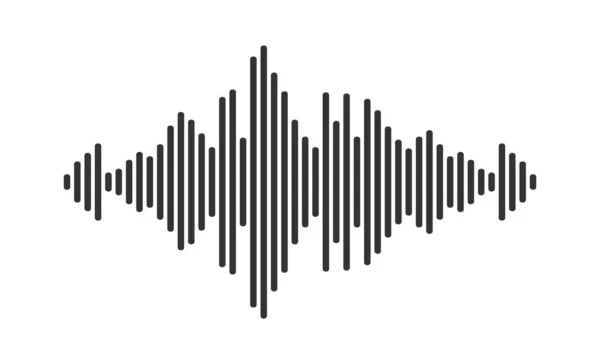

### Gerekli kütüphaneleri yükleme

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Activation, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


### Veri setini hazırlama ve özellik çıkarımını gerçekleştirme

In [16]:
audio_dataset_path = 'UrbanSound8K/audio/'
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [17]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])

extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])

X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

3555it [04:02, 14.50it/s]D:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8325it [08:56, 21.84it/s]D:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
D:\Anaconda\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [09:20, 15.58it/s]


### Etiketleri kodlama

In [18]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))


### Veriyi eğitim ve test setlerine ayırma

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Geliştirilmiş RNN Modeli Oluşturma

In [20]:
model = Sequential()


### 1. LSTM katmanı

In [21]:
model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))

### 2. LSTM katmanı

In [22]:
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))

### Tam bağlantılı (Dense) katmanlar

In [23]:
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)               

### Modeli Eğitme

In [24]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
219/219 [==============================] - 24s 78ms/step - loss: 2.0355 - accuracy: 0.2427 - val_loss: 1.8459 - val_accuracy: 0.3154
Epoch 2/50
219/219 [==============================] - 13s 60ms/step - loss: 1.7692 - accuracy: 0.3518 - val_loss: 1.5760 - val_accuracy: 0.4259
Epoch 3/50
219/219 [==============================] - 15s 68ms/step - loss: 1.5638 - accuracy: 0.4442 - val_loss: 1.4535 - val_accuracy: 0.4957
Epoch 4/50
219/219 [==============================] - 14s 66ms/step - loss: 1.4023 - accuracy: 0.5197 - val_loss: 1.2417 - val_accuracy: 0.5695
Epoch 5/50
219/219 [==============================] - 17s 79ms/step - loss: 1.2768 - accuracy: 0.5671 - val_loss: 1.2351 - val_accuracy: 0.5770
Epoch 6/50
219/219 [==============================] - 15s 67ms/step - loss: 1.1863 - accuracy: 0.6006 - val_loss: 1.1134 - val_accuracy: 0.6279
Epoch 7/50
219/219 [==============================] - 13s 62ms/step - loss: 1.0685 - accuracy: 0.6492 - val_loss: 0.9856 - val_accuracy:

### Eğitim ve doğrulama kayıplarını, doğruluk değerlerini görselleştirme

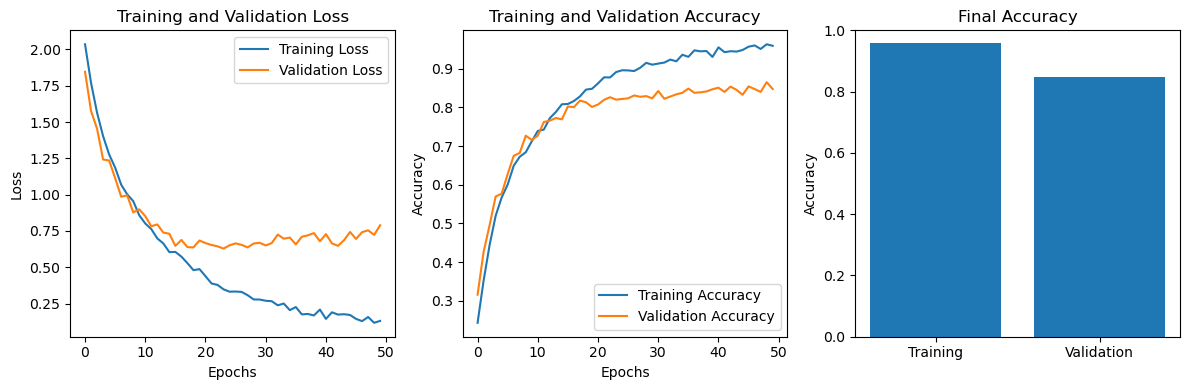

In [25]:
plt.figure(figsize=(12, 4))

# Kayıplar
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Doğruluk
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Doğruluk yüzdesini gösterme
plt.subplot(1, 3, 3)
plt.bar(['Training', 'Validation'], [history.history['accuracy'][-1], history.history['val_accuracy'][-1]])
plt.title('Final Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### İki ses dosyasının sınıfını tahmin etme ve görselleştirme

1/1 [==============================] - 1s 1s/step


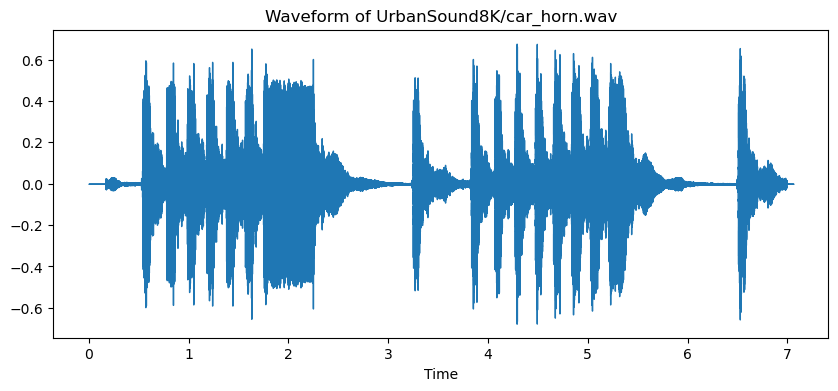

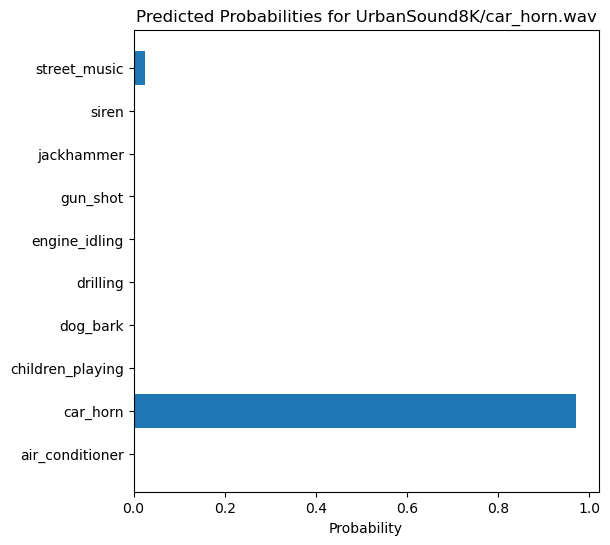

Predicted Class for UrbanSound8K/car_horn.wav: car_horn
Accuracy for UrbanSound8K/car_horn.wav: 97.19%
1/1 [==============================] - 0s 45ms/step


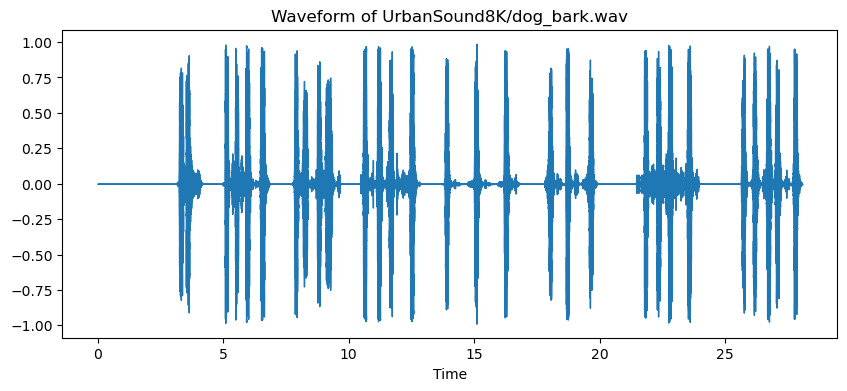

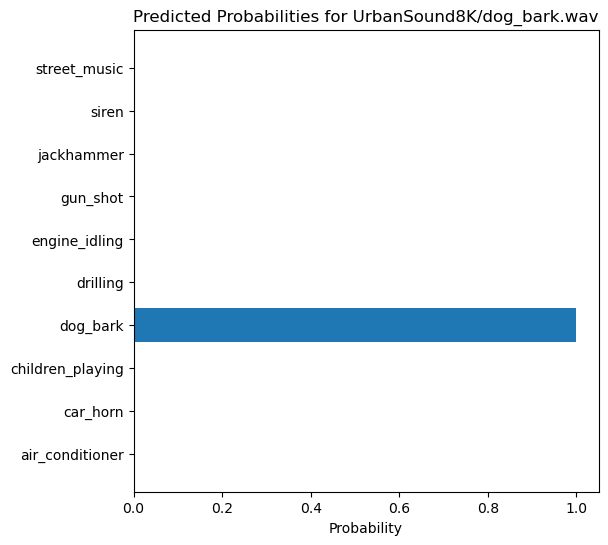

Predicted Class for UrbanSound8K/dog_bark.wav: dog_bark
Accuracy for UrbanSound8K/dog_bark.wav: 100.00%
Final Validation Accuracy: 84.77%


In [26]:
filenames = ["UrbanSound8K/car_horn.wav", "UrbanSound8K/dog_bark.wav"]

for filename in filenames:
    sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    mfccs_scaled_features = mfccs_scaled_features.reshape(1, mfccs_scaled_features.shape[0], 1)

    result_array = model.predict(mfccs_scaled_features)
    result_class = le.inverse_transform([np.argmax(result_array)])

    # Ses dosyasını görselleştirme
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(sound_signal, sr=sample_rate)
    plt.title(f'Waveform of {filename}')
    plt.show()

    # Tahmin sonucunu görselleştirme
    plt.figure(figsize=(6, 6))
    plt.barh(le.classes_, result_array[0])
    plt.title(f'Predicted Probabilities for {filename}')
    plt.xlabel('Probability')
    plt.show()

    print(f'Predicted Class for {filename}: {result_class[0]}')

    # Doğruluk yüzdesini yazdırma
    accuracy_percentage = result_array[0][le.transform([result_class[0]])[0]] * 100
    print(f'Accuracy for {filename}: {accuracy_percentage:.2f}%')

# Final Accuracy'yi yazdırma
final_accuracy = history.history['val_accuracy'][-1]
print(f'Final Validation Accuracy: {final_accuracy * 100:.2f}%')